## imports

In [1]:
import numpy as np
import os

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import load_img, ImageDataGenerator

## working and loading images

In [2]:
def get_all_files_name_in_path(path: str):
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


def get_ith_image_in_path(path: str, i: int):
    items = get_all_files_name_in_path(path)
    assert i < len(items), f'i should be less than {len(items)}'
    name = items[i]
    return f'{path}/{name}'


def get_an_image_randomly_in_path(path: str):
    items = get_all_files_name_in_path(path)
    i = np.random.randint(0, len(items))
    name = items[i]
    return f'{path}/{name}'


def get_path_of_food(name: str):
    return f'./data/Train/{name}'

In [3]:
class DecodedPrediction(object):
    def __init__(self, decode_predictions: list):
        self.decode_predictions = decode_predictions

    def get_first_prediction(self):
        return self.decode_predictions[0][0][1]

    def get_ith_prediction(self, i: int):
        return self.decode_predictions[0][i - 1][1]

In [4]:
def get_command(keras_model, keras_preprocess_input, keras_decode_predictions):
    def command(image_path: str):
        img = load_img(image_path, target_size=keras_model.input_shape[1:])
        x = np.array([np.array(img)])
        x = keras_preprocess_input(x)
        pred = keras_model.predict(x)
        return keras_decode_predictions(pred)

    return command

# Xception

In [5]:
from keras.applications import xception

In [6]:
xception_command = get_command(xception.Xception(weights='imagenet'), xception.preprocess_input,
                               xception.decode_predictions)

1/1 [==============================] - 0s 85ms/step
xception prediction: [[('n07697313', 'cheeseburger', 0.7463249), ('n07693725', 'bagel', 0.19694954), ('n02776631', 'bakery', 0.0015706028), ('n07684084', 'French_loaf', 0.0014718211), ('n07695742', 'pretzel', 0.0010258214)]]


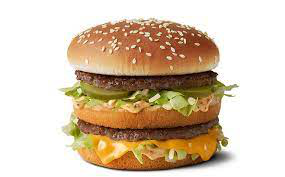

In [9]:
image_path = get_an_image_randomly_in_path(get_path_of_food('Burger'))
print('xception prediction:', xception_command(image_path))
load_img(image_path)

# MobileNet

In [10]:
from keras.applications import mobilenet

In [11]:
mobilenet_command = get_command(mobilenet.MobileNet(weights='imagenet'), mobilenet.preprocess_input,
                                mobilenet.decode_predictions)

1/1 [==============================] - 0s 21ms/step
mobilenet prediction: [[('n07697537', 'hotdog', 0.54063565), ('n07697313', 'cheeseburger', 0.26798907), ('n07579787', 'plate', 0.050620537), ('n07875152', 'potpie', 0.027487205), ('n03041632', 'cleaver', 0.013318223)]]


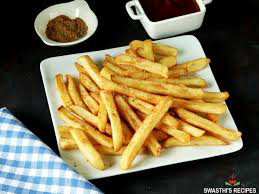

In [26]:
image_path = get_an_image_randomly_in_path(get_path_of_food('Fries'))
print('mobilenet prediction:', mobilenet_command(image_path))
load_img(image_path)

In [27]:
from keras.applications import inception_v3

In [28]:
inception_command = get_command(inception_v3.InceptionV3(weights='imagenet'), inception_v3.preprocess_input,
                                inception_v3.decode_predictions)

1/1 [==============================] - 0s 57ms/step
inception prediction: [[('n07684084', 'French_loaf', 0.9763174), ('n07716906', 'spaghetti_squash', 0.0024354954), ('n07871810', 'meat_loaf', 0.0017253227), ('n07717556', 'butternut_squash', 0.0014963939), ('n07717410', 'acorn_squash', 0.0012338024)]]


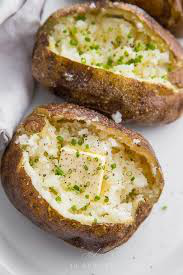

In [31]:
image_path = get_an_image_randomly_in_path(get_path_of_food('Baked Potato'))
print('inception prediction:', inception_command(image_path))
load_img(image_path)

## model + mapping from base model labels to data set labels

In [ ]:
# def add_final_mapping_layer(keras_model):
#     keras_model.trainable = False
# 
#     input_layer = keras.Input(keras_model.input_shape[1:])
#     keras_layer = keras_model(input_layer, training=False)
#     output_layer = keras.layers.Dense(10)(keras_layer)
#     model = keras.Model(input_layer, output_layer)
# 
#     return model

In [ ]:
# def learn_mapping_layer(model, keras_preprocess_input):
#     data_gen = ImageDataGenerator(preprocessing_function=keras_preprocess_input)
# 
#     train_ds = data_gen.flow_from_directory(
#         './data/Train',
#         target_size=model.input_shape[1:3],
#         batch_size=32
#     )
# 
#     val_ds = data_gen.flow_from_directory(
#         './data/Valid',
#         target_size=model.input_shape[1:3],
#         batch_size=32,
#         shuffle=False
#     )
# 
#     learning_rate = 0.01
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
#     loss = keras.losses.CategoricalCrossentropy(from_logits=True)
#     model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# 
#     history = model.fit(train_ds, epochs=10, validation_data=val_ds)
#     return model, history

In [32]:
base_model = xception.Xception(weights='imagenet')
keras_preprocess_input = xception.preprocess_input

data_gen = ImageDataGenerator(preprocessing_function=keras_preprocess_input)

base_train_generator = data_gen.flow_from_directory(
    './data/Train',
    target_size=base_model.input_shape[1:3],
    batch_size=100
)

base_valid_generator = data_gen.flow_from_directory(
    './data/Valid',
    target_size=base_model.input_shape[1:3],
    batch_size=100
)

input_layer = keras.Input(base_model.output_shape[1:])
map_layer = keras.layers.Dense(10)(input_layer)
map_model = keras.Model(input_layer, map_layer)

Found 15000 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.


In [ ]:
# map_model_input = base_model.predict(base_train_generator[0][0])

In [35]:
learning_rate = 0.01
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
map_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print(map_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 10010 (39.10 KB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# modified_exception = add_final_mapping_layer(
#     xception.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))

In [ ]:
# learn_mapping_layer(modified_exception, xception.preprocess_input)

In [36]:
# Data generator for the second neural network
def custom_data_generator(base_data_generator):
    for batch in base_data_generator:
        features = base_model.predict(batch[0])
        labels = batch[1]
        yield features, labels

In [ ]:
map_model.fit(
    custom_data_generator(base_train_generator),
    steps_per_epoch=len(base_train_generator),
    validation_data=custom_data_generator(base_valid_generator)
)

 50/150 [=========>....................] - ETA: 8:11 - loss: 2.1582 - accuracy: 0.5040

/Users/shayan/miniconda3/envs/ML-zoomcamp-playground/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4/4 [==============================] - 5s 1s/step


In [ ]:
class CustomModel(object):
    def __init__(self, base_model, map_model):
        self.base_model = base_model
        self.map_model = map_model
        self.input_shape = self.base_model.input_shape

    def predict(self, x):
        return self.map_model.predict(self.base_model.predict(x))


dir_path = './data/Train/'
classes = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]


def my_decode_prediction(pred):
    return dict(zip(classes, pred[0]))

In [ ]:
my_command = get_command(CustomModel(base_model, map_model), xception.preprocess_input, my_decode_prediction)
image_path = get_an_image_randomly_in_path(get_path_of_food('Burger'))
print('xception prediction:', my_command(image_path))
load_img(image_path)

In [ ]:
my_decode_prediction([[-1.7575898, 1.104011, -1.5568761, -1.2263432, -0.41464752, -1.5358437,
                       -1.7239212, -0.743358, -1.7970042, -1.8490225]])